In [1]:
#Color transferi için gerekli kütüphaneler import edildi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from google.colab.patches import cv2_imshow
%matplotlib inline

# **PART 1**

In [2]:


def color_transfer(source, destination): 


  #Color transfer edeceğimiz sonuç resmini kopyalıyoruz. çünkü bu resim üzerinden hem değişiklikler yapacağız 
  #hem de ileri safhalarda orjinal resmin mesela std lazım olacak

  #aynı resim üzerinde aynı anda işlemler yapmamız gerektiğinden çoğaltıyoruz.

  result = np.copy(destination)

  #RGB color space in LAB color space çevirilmesi
  sourceLab = cv2.cvtColor(source, cv2.COLOR_BGR2Lab)
  destinationLab = cv2.cvtColor(destination, cv2.COLOR_BGR2LAB)
  resultLab = cv2.cvtColor(result, cv2.COLOR_BGR2Lab)

  #Aşağıda yapılacak işlemlerden, mean std gibi, dolayı pixel değerleri float32 tipine çevirilir
  sourceLab = np.float32(sourceLab)
  destinationLab = np.float32(destinationLab)
  resultLab = np.float32(resultLab)

  #Her iki resimdeki LAB kanallarının cv2 kütüphanesi yardımıyla atanma işlemleri gerçekleştirildi
  sourceL, sourceA, sourceB = cv2.split(sourceLab)
  destinationL, destinationA, destinationB = cv2.split(destinationLab)
  resultL, resultA, resultB = cv2.split(resultLab)

  
  # Hedef resimdeki herbir LAB kanalından kendilerine ait ortalamaların çıkarılması
  resultL = destinationL - destinationL.mean()
  resultA = destinationA - destinationA.mean()
  resultB = destinationB - destinationB.mean()

  # Hedef resimdeki herbir kanalla kaynak ve hedef resime ait std değerlerinin oranlarıyla çarpılarak ölçeklendiriliyor
  resultL = resultL * (sourceL.std()/ destinationL.std())
  resultA = resultA * (sourceA.std()/ destinationA.std())
  resultB = resultB * (sourceB.std()/ destinationB.std())

  #Son olarak kaynak resime ait ortalama değerlerin eklenmesi
  resultL = resultL + sourceL.mean()
  resultA = resultA + sourceA.mean()
  resultB = resultB + sourceB.mean()


  #Yapılan bu işlemler sonucunda pixel değerlerinin 0-255 arasına çekilmesi için hazır np.clip fonksiyonunu kullanıyoruz.
  resultL = np.clip(resultL, 0, 255)
  resultA = np.clip(resultA, 0, 255)
  resultB = np.clip(resultB, 0, 255)

  #LAB kanallarını tekrar merge ediyoruz
  resultLab = cv2.merge([resultL, resultA, resultB])

  #float32'den uint8'e çeviriyoruz.
  resultLab = np.uint8(resultLab)

  #En son olarak da LAB'dan tekrar BGR kanalına çeviriyoruz. Burada cv2 kullanıldığından sırası böyle.
  result =  cv2.cvtColor(resultLab, cv2.COLOR_LAB2BGR)


  return source, destination, result



(393, 700, 3) (437, 700, 3)


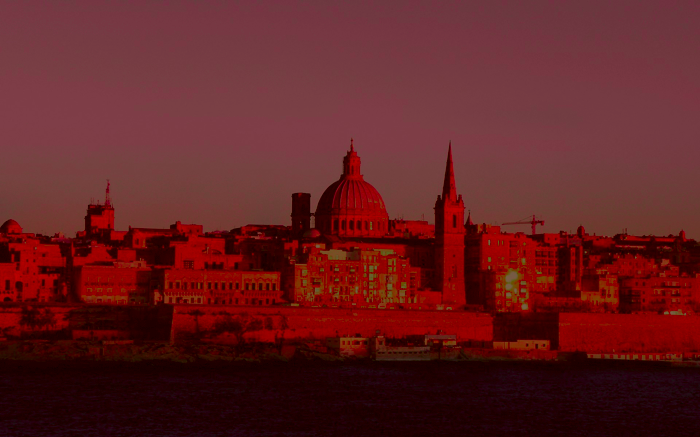

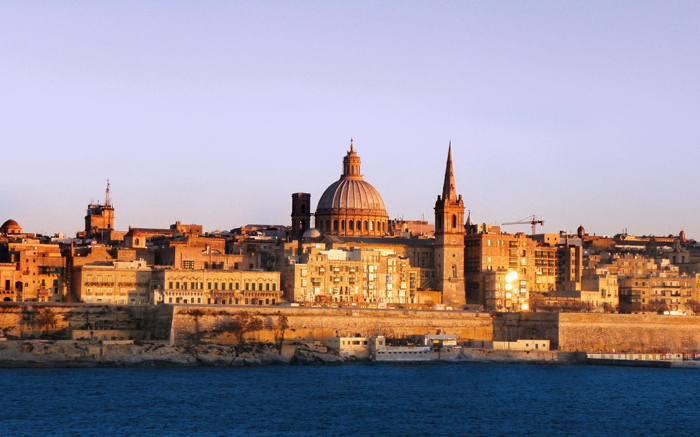

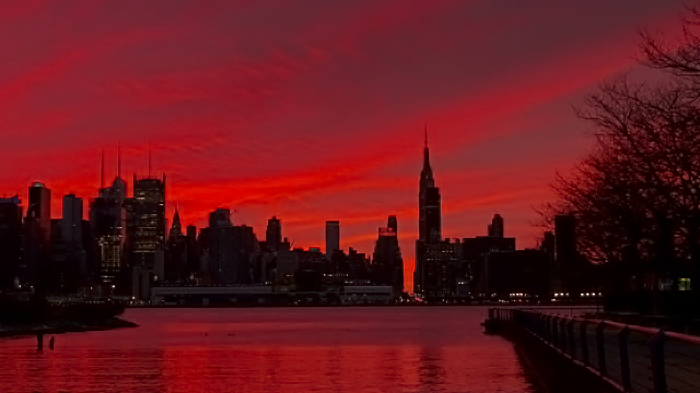

In [4]:
#Burada ben 1. resmi kullandım
source = cv2.imread("/content/sample_data/tar_01.png")
destination = cv2.imread("/content/sample_data/in_01.png")
print(source.shape, destination.shape)
a, b, result = color_transfer(source, destination)

#Yukarıda anlatılan fonksiyon source ve destination imagalarına uygulandklarında sonuç aşağıdaki gibi olmaktadır.
cv2_imshow(result)
cv2_imshow(destination)
cv2_imshow(source)




# **PART 2**


In [5]:

#En benzer alanların color transferi için 
#Sum of Square Difference yöntemini kullanarak skor alma fonksiyonu 

def skor(im1, im2):  
  return np.sum(np.sum((im1[:, :, 0:3] - im2[:, :, 0:3])**2)) 

In [6]:
#Color transfer yapmadan önce resmi eşit bölmelere ayırmaya yarayan fonksiyon
#Böylece resimler eşit bölmelere ayrılır.
def divide_picture(image,  bolme):
    img = image
    yukseklik, genislik, kanallar = img.shape
    parcalar = []
    for i_height in range(bolme ):
      for i_width in range(bolme ):
        x = genislik//bolme * i_width 
        y = yukseklik//bolme * i_height 
        h = (yukseklik // bolme)
        w = (genislik // bolme )
        parcalar.append(img[y:y+h, x:x+w])
    return  parcalar


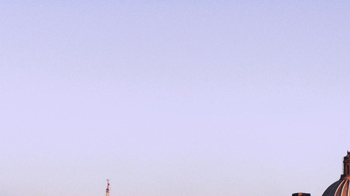

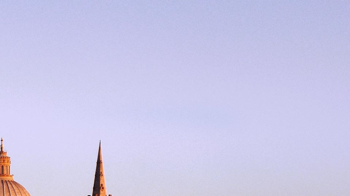

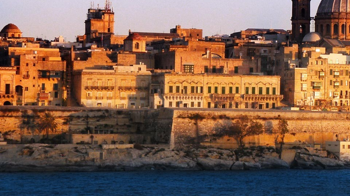

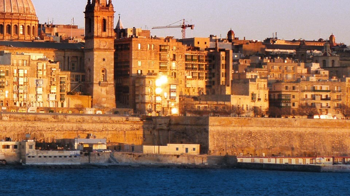

In [7]:

source = cv2.imread("/content/sample_data/tar_01.png")
destination = cv2.imread("/content/sample_data/in_01.png")


#Resimleri eşit bölmelere ayırmadan önce de croplayarak eşit boyutlara getirildi.
M = min(source.shape[0], destination.shape[0])
N = min(source.shape[1], destination.shape[1])

source = source[:M, :N]
destination = destination[:M, :N]

source_parts  = divide_picture(source, 2) # Resmi 4 eşit parçaya ayırdım ilk olarak
destination_parts = divide_picture(destination, 2) # Aşağıda parçaları bulunuyor. Daha sonra fonksiyon içine aldım tüm işlemleri, burada göstermek istedim.
for i in destination_parts:
  cv2_imshow(i)




    
   



In [8]:
# Destination resmini de 4 parçaya ayırmıştık. Buradaki 1 parçayı alıp source resminde yer alan yine 4 parça üzerinde gezdiriyoruz.
# Burada Sum of Square diffference ile benzerlik skoru hesapliyoruz ve en küçük skora sahip parça ile color transformation yapıyoruz.
# Bu işlemi herbir destination parçası için gerçekleştiriyoruz.

# Destinationdaki color transformation gören parçaları tutmak için res listesi tanımladık
res = []
for i in destination_parts: 
  min_skor = float('inf') # ssd benzerlik skorunu tutması için sonsuzda bir sayi tanımladık.
  my_j = None #Min skora sahip kaynak resmin parçasını tutması için değişken tanımladık

  for j in source_parts:
    my_skor  =  skor(i, j)
    if my_skor < min_skor:
      min_skor = my_skor
      my_j = j
  a, b, r = color_transfer(my_j, i)
  res.append(r)
  #cv2_imshow(r)


    


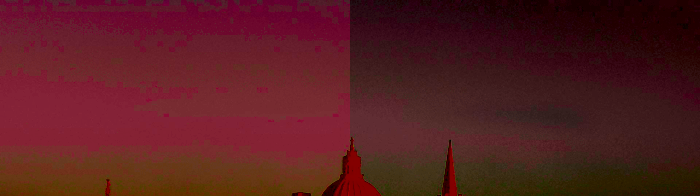

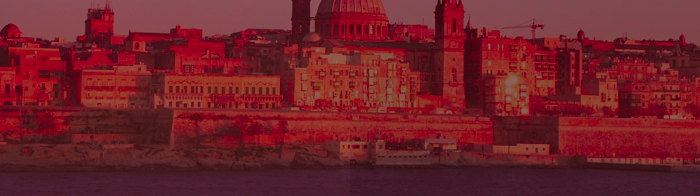

In [9]:
cv2_imshow((np.concatenate((res[0], res[1]), axis = 1)) )
cv2_imshow((np.concatenate((res[2], res[3]), axis = 1)) )
part1 = np.concatenate((res[0], res[1]), axis = 1)
part2 = np.concatenate((res[2], res[3]), axis = 1)
parts_whole  = np.concatenate((part1, part2), axis = 0)

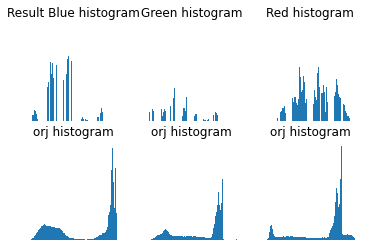

<Figure size 864x864 with 0 Axes>

In [11]:
red = parts_whole[:, :, 0]
green= parts_whole[:, :, 1]
blue = parts_whole[:, :, 2]

red_d = destination[:, :, 0]
green_d= destination[:, :, 1]
blue_d = destination[:, :, 2]

fig, ax = plt.subplots(ncols = 3, nrows = 2)
plt.figure(figsize=(12, 12))
ax[0,0].hist(red.ravel(),  bins= 256)
ax[0,0].set_title('Result Blue histogram')
ax[0,0].axis('off')
ax[0,1].hist(green.ravel(), bins= 256)
ax[0,1].set_title('Green histogram')
ax[0,1].axis('off')
ax[0,2].hist(blue.ravel(), bins= 256)
ax[0,2].set_title('Red histogram')
ax[0,2].axis('off')

ax[1,0].hist(red_d.ravel(),  bins= 256)
ax[1,0].set_title('orj histogram')
ax[1,0].axis('off')
ax[1,1].hist(green_d.ravel(), bins= 256)
ax[1,1].set_title('orj histogram')
ax[1,1].axis('off')
ax[1,2].hist(blue_d.ravel(), bins= 256)
ax[1,2].set_title('orj histogram')
ax[1,2].axis('off')
plt.show()

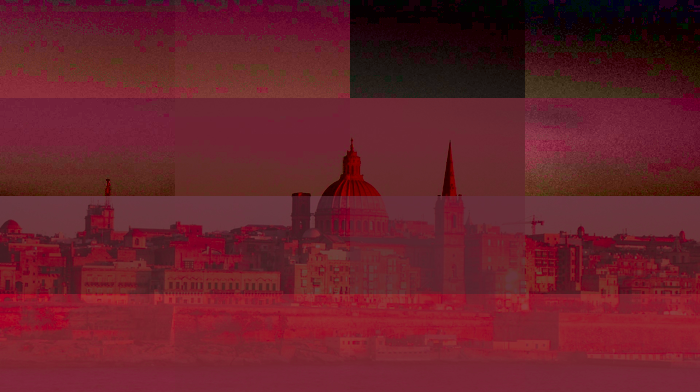

In [ ]:

def partial_color_transf(div):
  source = cv2.imread("/content/sample_data/tar_01.png")
  destination = cv2.imread("/content/sample_data/in_01.png")


  #cropping the one image to make them equal
  M = min(source.shape[0], destination.shape[0])
  N = min(source.shape[1], destination.shape[1])

  source = source[:M, :N]
  destination = destination[:M, :N]

  source_parts  = divide_picture(source, div)
  destination_parts = divide_picture(destination, div)
  res = []
  for i in destination_parts: 
    min_skor = float('inf') # ssd benzerlik skorunu tutması için sonsuzda bir sayi tanımladık.
    my_j = None #Min skora sahip kaynak resmin parçasını tutması için değişken tanımladık

    for j in source_parts:
      my_skor  =  skor(i, j)
      if my_skor < min_skor:
        min_skor = my_skor
        my_j = j
    a, b, r = color_transfer(my_j, i)
    res.append(r)
  return res

res = partial_color_transf(4) # burada yapılan tüm ilemleri fonksiyon içine aldım ve bu sefer 16 parça ile renk transferi yaptım

part1 = np.concatenate((res[0], res[1], res[2], res[3]), axis = 1)
part2 = np.concatenate((res[4], res[5], res[6], res[7]), axis = 1)
part3 = np.concatenate((res[8], res[9], res[10], res[11]), axis = 1)
part4 = np.concatenate((res[12], res[13], res[14], res[15]), axis = 1)

parts_whole  = np.concatenate((part1, part2, part3, part4), axis = 0)
cv2_imshow(parts_whole)


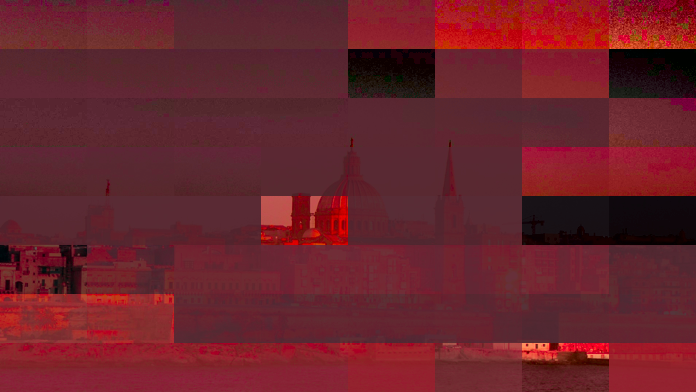

In [ ]:
res = partial_color_transf(8)

part1 = np.concatenate((res[0], res[1], res[2], res[3], res[4], res[5], res[6], res[7]), axis = 1)
part2 = np.concatenate((res[8], res[9], res[10], res[11], res[12], res[13], res[14],res[15]), axis = 1)
part3 = np.concatenate((res[16], res[17], res[18], res[19], res[20],res[21], res[22],res[23]), axis = 1)
part4 = np.concatenate((res[24], res[25], res[26], res[27], res[28], res[29], res[30], res[31]), axis = 1)

part5 = np.concatenate((res[32], res[33], res[34], res[35], res[36], res[37], res[38],res[39]), axis = 1)
part6 = np.concatenate((res[40], res[41], res[42], res[43], res[44],res[45], res[46],res[47]), axis = 1)
part7 = np.concatenate((res[48], res[49], res[50], res[51], res[52], res[53], res[54], res[55]), axis = 1)
part8 = np.concatenate((res[56], res[57], res[58], res[59], res[60], res[61], res[62], res[63]), axis = 1)



parts_whole  = np.concatenate((part1, part2, part3, part4, part5, part6, part7, part8), axis = 0)
cv2_imshow(parts_whole)
